<a href="https://colab.research.google.com/github/danilsab24/Semantic_Segmentation_Potsdam/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/danilsab24/Semantic_Segmentation_Potsdam.git

Cloning into 'Semantic_Segmentation_Potsdam'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (36/36), done.
Receiving objects: 100% (50/50), 9.45 KiB | 9.45 MiB/s, done.
Resolving deltas: 100% (23/23), done.
remote: Total 50 (delta 23), reused 28 (delta 8), pack-reused 0


In [2]:
from Semantic_Segmentation_Potsdam.Unet import UNET
from Semantic_Segmentation_Potsdam.dataset import Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
import os

directory_path = "/content/drive/MyDrive"  # Inserisci il percorso della directory
prefix_to_remove = "top_potsdam"          # Prefisso da cercare nei nomi dei file

# Elenco dei file nella directory
file_list = os.listdir(directory_path)

# Itera attraverso i file e elimina quelli che iniziano con il prefisso specificato
for filename in file_list:
    if filename.startswith(prefix_to_remove):
        file_path = os.path.join(directory_path, filename)
        os.remove(file_path)
        print(f"File eliminato: {filename}")

print("Eliminazione completata.")
'''

Eliminazione completata.


In [4]:
# Librerie per il Dataset
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from albumentations import Compose, RandomCrop, HorizontalFlip, Normalize

# Visualizzazione delle immagini
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from PIL import Image
import os
import cv2

In [5]:
images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
labels_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels"

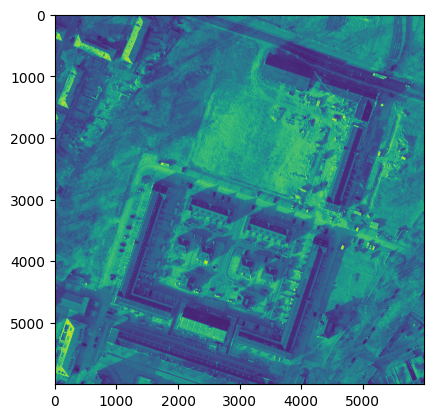

In [ ]:
#Quick understanding of the dataset
temp_img = cv2.imread("/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG/top_potsdam_2_10_IRRG.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...

In [ ]:
# Load the label image
temp_mask = cv2.imread("/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10_label.tif")

# Define the class mapping
class_mapping = {
    (255, 255, 255): 0,  # Impervious surfaces
    (0, 0, 255): 1,      # Building
    (0, 255, 255): 2,    # Low vegetation
    (0, 255, 0): 3,      # Tree
    (255, 255, 0): 4,    # Car
    (255, 0, 0): 5      # Clutter/background
}

# Initialize an array to hold the counts for each class
class_counts = np.zeros(len(class_mapping), dtype=int)

# Loop through the pixels and count occurrences of each class
for rgb, class_idx in class_mapping.items():
    mask = np.all(temp_mask == np.array(rgb), axis=-1)
    class_counts[class_idx] = np.sum(mask)

# Print the class labels and their respective counts
for class_idx, count in enumerate(class_counts):
    class_label = next(key for key, value in class_mapping.items() if value == class_idx)
    print("Class {}: {} - Count: {}".format(class_idx, class_label, count))

Class 0: (255, 255, 255) - Count: 7433797
Class 1: (0, 0, 255) - Count: 4944599
Class 2: (0, 255, 255) - Count: 313148
Class 3: (0, 255, 0) - Count: 2679388
Class 4: (255, 255, 0) - Count: 15182061
Class 5: (255, 0, 0) - Count: 5447007


In [ ]:
def print_image_shapes(path):
    for filename in os.listdir(path):
        if filename.endswith(".tif") or filename.endswith(".png"):
            image_path = os.path.join(path, filename)
            image = Image.open(image_path)
            print(f"Image: {filename}, Shape: {image.size}")

print("Image shapes in 'images_IRRG' folder:")
print_image_shapes(images_path)

print("\nImage shapes in 'labels' folder:")
print_image_shapes(labels_path)

Image shapes in 'images_IRRG' folder:
Image: top_potsdam_2_10_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_2_11_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_2_12_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_2_13_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_2_14_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_3_10_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_3_11_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_3_12_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_3_13_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_3_14_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_4_10_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_4_11_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_4_12_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_4_13_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_4_14_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_4_15_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_5_10_IRRG.tif, Shape: (6000, 6000)
Image: top_potsdam_5_11_IRRG.tif, Shape: (60

In [6]:
from PIL import Image
import os

# Percorso delle immagini originali e destinazione delle patch
original_images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG"
patch_images_save_path = "/content/"
patch_folder_name = "images_patches"

# Dimensioni delle patch desiderate
patch_size = 250  # Dimensione delle patch, puoi regolarla in base alle tue esigenze

# Crea la cartella per le patch se non esiste
patch_folder_path = os.path.join(patch_images_save_path, patch_folder_name)
if not os.path.exists(patch_folder_path):
    os.mkdir(patch_folder_path)

# Ciclo attraverso le immagini originali
for image_filename in os.listdir(original_images_path):
  if image_filename.endswith(".tif"):
      image_path = os.path.join(original_images_path, image_filename)

      # Carica l'immagine
      image = Image.open(image_path)

      # Estrai le patch dall'immagine
      num_patches = (image.width // patch_size) * (image.height // patch_size)
      for i in range(0, image.width, patch_size):
          for j in range(0, image.height, patch_size):
              patch = image.crop((i, j, i + patch_size, j + patch_size))
              patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{i}_{j}.tif"   # Genera un nome univoco per ogni patch
              patch_save_location = os.path.join(patch_folder_path, patch_filename)

              # Controlla se la patch esiste già
              if not os.path.exists(patch_save_location):
                  patch.save(patch_save_location)

print("Riduzione delle immagini in patch completata.")


Riduzione delle immagini in patch completata.


In [7]:
import os

# Percorso della cartella delle patch
patch_folder_path = "/content/images_patches"

# Contatore per le immagini
image_count = 0

# Ciclo attraverso i file nella cartella delle patch
for filename in os.listdir(patch_folder_path):
    if filename.endswith(".tif"):
        image_count += 1

print(f"Numero totale di immagini nella cartella delle patch: {image_count}")

Numero totale di immagini nella cartella delle patch: 21888


In [8]:
# Percorso delle immagini originali e destinazione delle patch
original_images_path = "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels"
patch_Labels_save_path = "/content/"
patch_folder_name = "labels_patches"

# Dimensioni delle patch desiderate
patch_size = 250  # Dimensione delle patch, puoi regolarla in base alle tue esigenze

# Crea la cartella per le patch se non esiste
patch_folder_path = os.path.join(patch_Labels_save_path, patch_folder_name)
if not os.path.exists(patch_folder_path):
    os.mkdir(patch_folder_path)


# Ciclo attraverso le immagini originali
for image_filename in os.listdir(original_images_path):
    if image_filename.endswith(".tif"):
        image_path = os.path.join(original_images_path, image_filename)

        # Carica l'immagine
        image = Image.open(image_path)

        # Estrai le patch dall'immagine
        num_patches = (image.width // patch_size) * (image.height // patch_size)
        for i in range(0, image.width, patch_size):
            for j in range(0, image.height, patch_size):
                patch = image.crop((i, j, i + patch_size, j + patch_size))
                patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{i}_{j}.tif"   # Genera un nome univoco per ogni patch
                patch_save_location = os.path.join(patch_folder_path, patch_filename)

                # Controlla se la patch esiste già
                if not os.path.exists(patch_save_location):
                    patch.save(patch_save_location)

print("Riduzione delle immagini in patch completata.")

Riduzione delle immagini in patch completata.


In [9]:
# Percorso della cartella delle patch
patch_folder_path = "/content/labels_patches"

# Contatore per le immagini
image_count = 0

# Ciclo attraverso i file nella cartella delle patch
for filename in os.listdir(patch_folder_path):
    if filename.endswith(".tif"):
        image_count += 1

print(f"Numero totale di immagini nella cartella delle patch: {image_count}")

Numero totale di immagini nella cartella delle patch: 21888


In [ ]:
'''
import os

# Percorso della cartella contenente le immagini
images_folder_path = "/content"

# Ciclo attraverso i file nella cartella
for filename in os.listdir(images_folder_path):
    if filename.startswith("top_potsdam") and filename.endswith(".tif"):
        file_path = os.path.join(images_folder_path, filename)
        os.remove(file_path)
        print(f"File eliminato: {filename}")

print("Eliminazione completata.")
'''

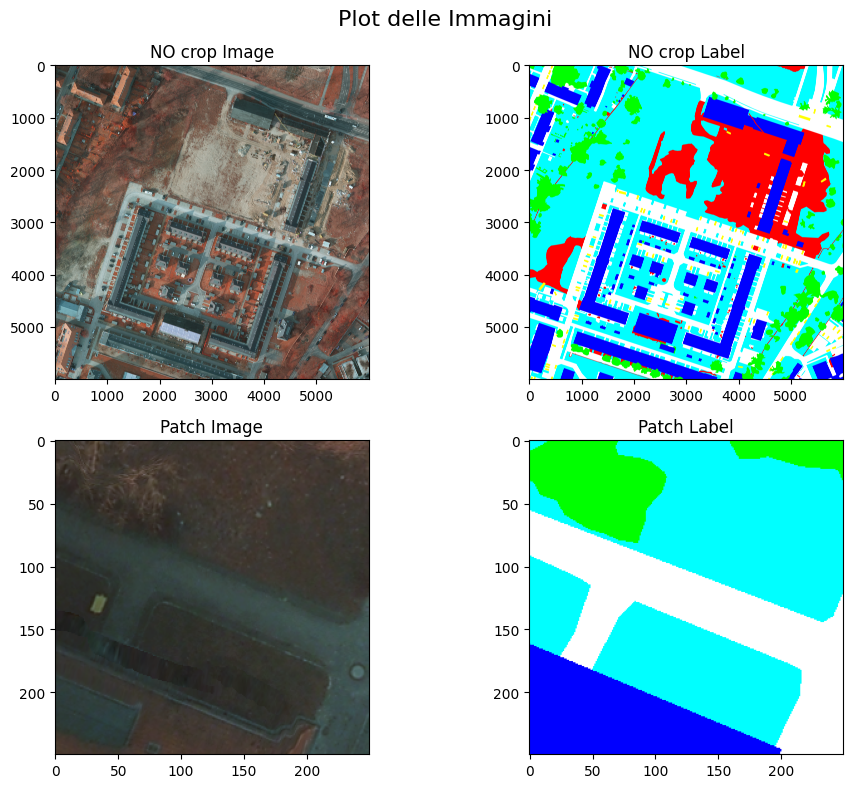

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Percorsi delle immagini
image_paths = [
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/images_IRRG/top_potsdam_2_10_IRRG.tif",
    "/content/drive/MyDrive/Semantic_Segmentation_Postdam/labels/top_potsdam_2_10_label.tif",
    "/content/images_patches/top_potsdam_2_10_IRRG_patch_0_0.tif",
    "/content/labels_patches/top_potsdam_2_10_label_patch_0_0.tif"
]

# Titoli per le immagini
image_titles = [
    "NO crop Image",
    "NO crop Label",
    "Patch Image",
    "Patch Label"
]

# Creazione di una griglia 2x2 per il plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Plot delle Immagini", fontsize=16)

for i in range(4):
    row = i // 2
    col = i % 2

    # Caricamento e visualizzazione dell'immagine
    image = Image.open(image_paths[i])
    axes[row, col].imshow(image)
    axes[row, col].set_title(image_titles[i])
    axes[row, col].axis('on')

plt.tight_layout()
plt.show()


In [ ]:
def print_image_shapes(path):
    for filename in os.listdir(path):
        if filename.endswith(".tif") or filename.endswith(".jpg"):
            image_path = os.path.join(path, filename)
            image = Image.open(image_path)
            print(f"Image: {filename}, Shape: {image.size}")

print("Patch shapes in 'images_IRRG' folder:")
print_image_shapes(patch_Images_save_path)

print("\nPatch shapes in 'labels' folder:")
print_image_shapes(patch_Labels_save_path)

In [10]:
train_transform = Compose([
    RandomCrop(height=256, width=256),  # Esempio di data augmentation: ritaglio casuale
    HorizontalFlip(p=0.5),  # Esempio di data augmentation: flip orizzontale
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione
])

# Trasformazione per il test (solo normalizzazione)
test_transform = transforms.Compose([
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione
])

In [12]:
patch_Images_save_path = "/content/images_patches"
patch_Labels_save_path = "/content/labels_patches"
# Creazione del dataset
dataset = Data(patch_Images_save_path, patch_Labels_save_path)

# Divisione dei dati in train, validation e test set
val_split = 0.1
test_split = 0.1
dataset_size = len(dataset)
val_size = int(val_split * dataset_size)
test_size = int(test_split * dataset_size)
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Applica le trasformazioni al trainset e al testset
train_dataset.transform = train_transform
val_dataset.transform = train_transform
test_dataset.transform = test_transform

# Creazione dei DataLoader
batch_size = 5  # Definisci la dimensione del batch desiderata

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [13]:
# Stampa delle dimensioni dei dataset
print(f"Dataset size: {len(dataset)} samples")
print(f"Train dataset size: {len(train_dataset)} samples")
print(f"Validation dataset size: {len(val_dataset)} samples")
print(f"Test dataset size: {len(test_dataset)} samples")

Dataset size: 21888 samples
Train dataset size: 17512 samples
Validation dataset size: 2188 samples
Test dataset size: 2188 samples


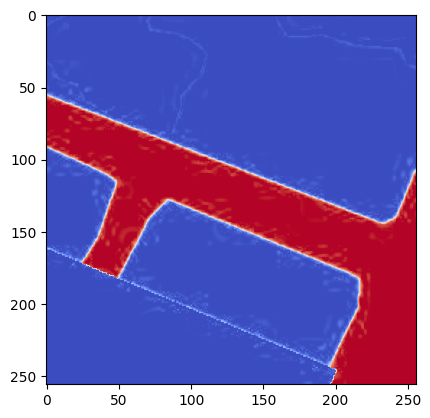

In [ ]:
img = plt.imread('/content/drive/MyDrive/Semantic_Segmentation_Postdam/new_labels_data/top_potsdam_2_10_label.tif_patch_0_0.jpg')
plt.imshow(img[:, :, 0], cmap=plt.cm.coolwarm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import albumentations as A

def plot_images_from_loader(loader, num_images=4):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Inizializza l'augmenter per l'inversione della normalizzazione
    inv_normalize = A.Compose([A.Normalize(mean=[0, 0, 0], std=[1/0.5, 1/0.5, 1/0.5]),
                               A.Normalize(mean=[-0.5, -0.5, -0.5], std=[1, 1, 1])])

    # Inverte la normalizzazione delle immagini
    images = inv_normalize(image=images.numpy())['image']
    print(np.shape(images))

    # Trasponi i canali delle immagini se necessario (da CxHxW a HxWxC)
    images = np.transpose(images, (1, 2, 0))

    # Mostra le immagini
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Utilizzo della funzione per plottare le immagini dal train loader
plot_images_from_loader(train_loader, num_images=4)


(5, 256, 256, 3)


ValueError: ignored

TypeError: ignored

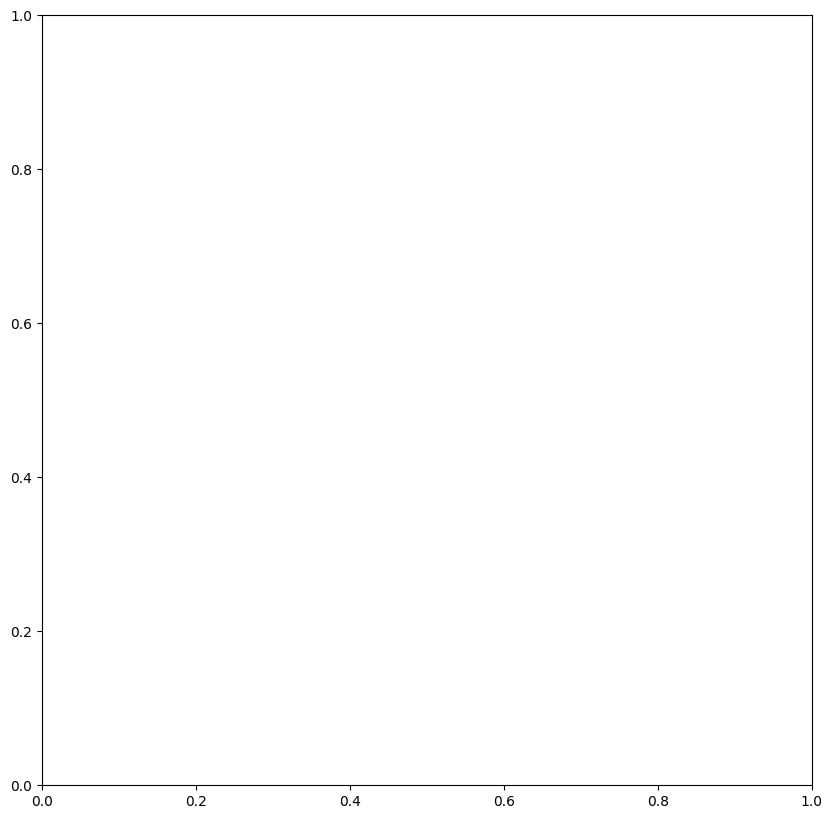

In [ ]:
# Visualizza alcune immagini del trainset
def show_images(images, n_rows=4):
    grid = make_grid(images, nrow=n_rows)
    plt.figure(figsize=(10, 10))

    grid = make_grid(images, nrow=n_rows)
    #grid_np = grid.permute(1, 2, 0).numpy()  # Converti il tensore in un array NumPy
    #grid_pil = Image.fromarray(np.uint8(grid_np * 255))

    plt.imshow(grid)
    plt.axis('off')
    plt.show()

# Carica il primo batch di immagini dal DataLoader di addestramento
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Visualizza le immagini
show_images(images)